In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(len(X_train), len(X_test))

60000 10000


In [3]:
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

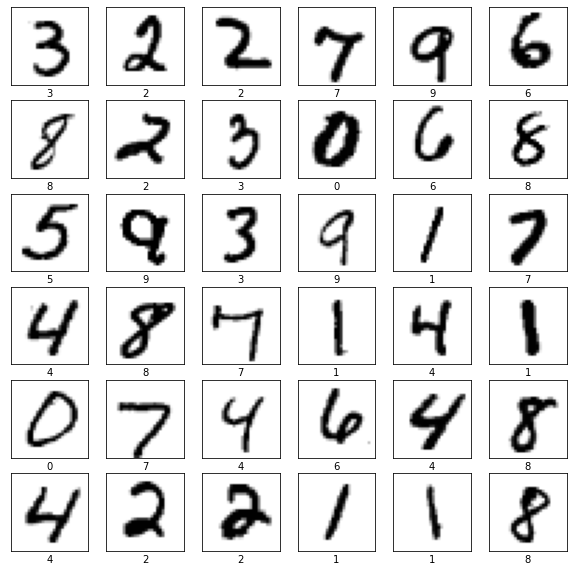

In [4]:
rndsuff = np.random.randint(0, len(X_train)-1, size=len(X_train), dtype='l')

# Show images and labels
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6, 6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[rndsuff[i]], cmap=plt.cm.binary)
    plt.xlabel(y_train[rndsuff[i]])
plt.show()

In [5]:
# 총 6만장 2중, 6000장, 1000장
X_valid, X_train = X_train[:1000], X_train[55000:]
y_valid, y_train = y_train[:1000], y_train[55000:]

X_test = X_test[:1000]
y_test = y_test[:1000]

In [6]:
def classifier(predictions) :
    rtn = []    
    for prediction in predictions :
        rtn.append(np.argmax(prediction))                
    return np.array(rtn)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])  

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 2s 386us/sample - loss: 0.9281 - accuracy: 0.7798 - val_loss: 0.4775 - val_accuracy: 0.8560
Epoch 2/10
5000/5000 [==============================] - 1s 281us/sample - loss: 0.3006 - accuracy: 0.9124 - val_loss: 0.4126 - val_accuracy: 0.8730
Epoch 3/10
5000/5000 [==============================] - 1s 285us/sample - loss: 0.2450 - accuracy: 0.9270 - val_loss: 0.3911 - val_accuracy: 0.8770
Epoch 4/10
5000/5000 [==============================] - 1s 282us/sample - loss: 0.2145 - accuracy: 0.9364 - val_loss: 0.3723 - val_accuracy: 0.8940
Epoch 5/10
5000/5000 [==============================] - 1s 280us/sample - loss: 0.1925 - accuracy: 0.9470 - val_loss: 0.3427 - val_accuracy: 0.9010
Epoch 6/10
5000/5000 [==============================] - 1s 281us/sample - loss: 0.1803 - accuracy: 0.9488 - val_loss: 0.3385 - val_accuracy: 0.9070
Epoch 7/10
5000/5000 [==============================] - 1s 288us

In [11]:
_, test_acc = model.evaluate(X_test, y_test)
print('Test acc = ', test_acc)

1000/1000 [==============================] - 0s 139us/sample - loss: 0.3066 - accuracy: 0.9170
Test acc =  0.917


In [12]:
predictions = classifier(model.predict(X_test))

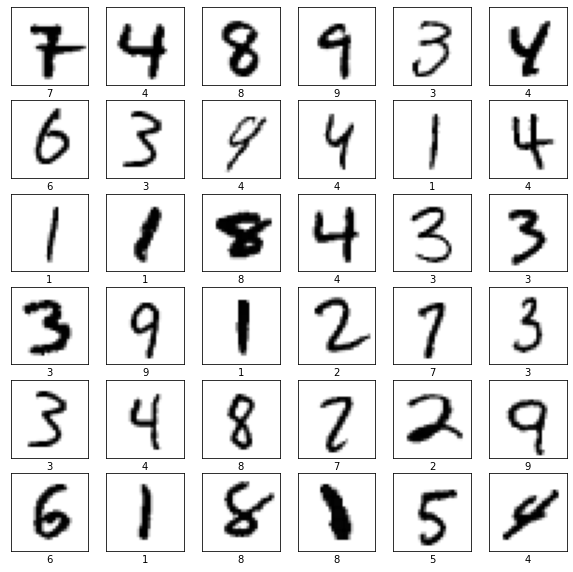

In [13]:
rndsuff = np.random.randint(0, len(X_test)-1, size=len(X_test), dtype='l')

# Show images and labels
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6, 6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[rndsuff[i]], cmap=plt.cm.binary)
    plt.xlabel(predictions[rndsuff[i]])
plt.show()

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])  

In [15]:
# Oprimization 필수 API ...
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

In [16]:
# Graph를 표현하려면 CallBack Class를 Overwirte해야 함
# 그냥 저장해두고 복붙하는 것이 좋다.
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.epoch_train_loss = []
        self.epoch_train_acc = []
        self.epoch_val_loss = []
        self.epoch_val_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_train_loss.append(logs['loss'])
        self.epoch_train_acc.append(logs['accuracy'])
        self.epoch_val_loss.append(logs['val_loss'])
        self.epoch_val_acc.append(logs['val_accuracy'])
        
batch_stats = CollectBatchStats()

In [17]:
# LRS
def scheduler(epoch, lr):
    guide_epoch = [10, 20, 30, 40, 50] 
    if epoch in guide_epoch: 
        lr = lr  * 0.1
    else:
        lr = lr
    return lr

cb_learning_rate_schedule = LearningRateScheduler(scheduler)

In [18]:
# Best Model Back up callback checkpoint callback
cb_checkpoint = ModelCheckpoint(filepath='./model/best_model.hdf5', 
                                monitor='val_accuracy',
                                verbose=0, 
                                save_best_only=True)

In [19]:
#early stopping callback
cb_early_stopping = EarlyStopping(monitor='val_accuracy',
                                  patience=20)

In [20]:
callbacks = [batch_stats,
             # cb_learning_rate_schedule,
             cb_checkpoint,
             cb_early_stopping]

In [21]:
model.compile(optimizer='adam',
              # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train,
          # batch_size=100,
          epochs=200,
          callbacks=callbacks,
          validation_data=(X_valid, y_valid))

Train on 5000 samples, validate on 1000 samples
Epoch 1/200
5000/5000 [==============================] - 2s 403us/sample - loss: 0.8454 - accuracy: 0.7896 - val_loss: 0.4765 - val_accuracy: 0.8630
Epoch 2/200
5000/5000 [==============================] - 1s 297us/sample - loss: 0.2794 - accuracy: 0.9230 - val_loss: 0.3760 - val_accuracy: 0.8900
Epoch 3/200
5000/5000 [==============================] - 2s 303us/sample - loss: 0.2189 - accuracy: 0.9376 - val_loss: 0.3490 - val_accuracy: 0.8980
Epoch 4/200
5000/5000 [==============================] - 1s 298us/sample - loss: 0.1913 - accuracy: 0.9454 - val_loss: 0.3318 - val_accuracy: 0.9030
Epoch 5/200
5000/5000 [==============================] - 1s 297us/sample - loss: 0.1662 - accuracy: 0.9568 - val_loss: 0.3248 - val_accuracy: 0.9120
Epoch 6/200
5000/5000 [==============================] - 1s 289us/sample - loss: 0.1525 - accuracy: 0.9574 - val_loss: 0.3172 - val_accuracy: 0.9040
Epoch 7/200
5000/5000 [==============================] - 1

In [23]:
def plot(batch_stats):
    plt.figure(figsize = (20, 20))

    plt.subplot(2,2,3)
    plt.ylabel(" Loss", fontsize=15)
    plt.xlabel("Epochs" , fontsize=15)
    plt.ylim([0,2])
    plt.plot(batch_stats.epoch_train_loss, label = 'train loss per epoch')
    plt.plot(batch_stats.epoch_val_loss, label = 'validation loss per epoch')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.ylabel(" Accuracy", fontsize=15)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylim([0,1])
    plt.plot(batch_stats.epoch_train_acc, label = 'train accuracy per epoch')
    plt.plot(batch_stats.epoch_val_acc, label = 'validation accuracy per epoch')
    plt.grid(True)
    plt.legend()   

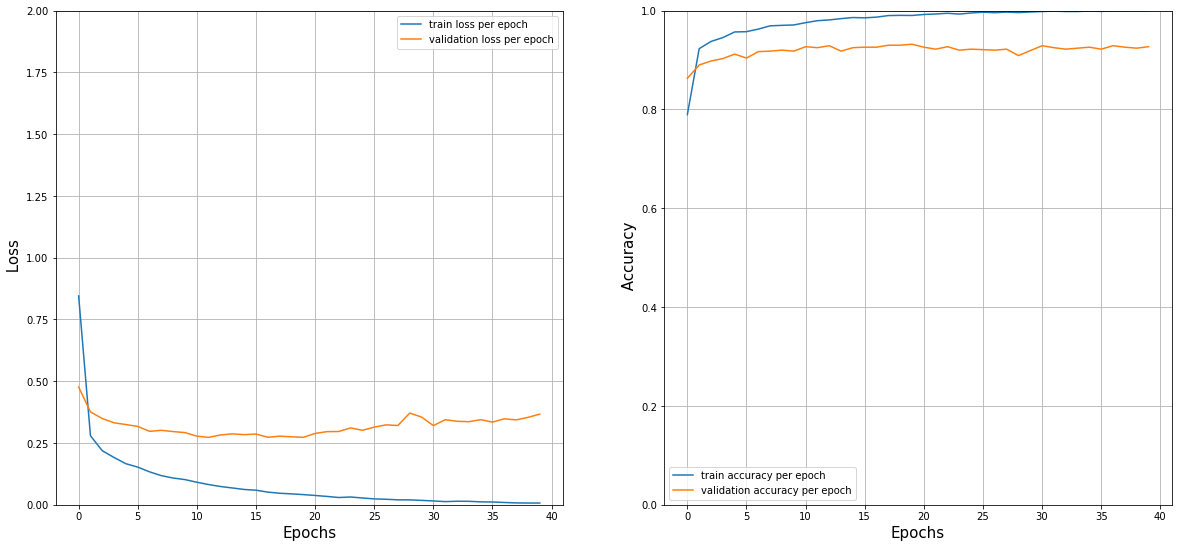

In [24]:
plot(batch_stats)

In [25]:
saved_model = load_model('./model/best_model.hdf5')

In [26]:
_, test_acc = saved_model.evaluate(X_test, y_test)
print('Test acc = ', test_acc)

1000/1000 [==============================] - 0s 247us/sample - loss: 0.2125 - accuracy: 0.9380
Test acc =  0.938
